<a href="https://colab.research.google.com/github/EssaAlsharif/Identify-Customer-Segments/blob/main/Identify_Customer_Segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
!git clone https://github.com/EssaAlsharif/Identify-Customer-Segments
%cd Identify-Customer-Segments
!ls

fatal: destination path 'Identify-Customer-Segments' already exists and is not an empty directory.
/content/Identify-Customer-Segments
AZDIAS_Feature_Summary.csv	  terms.pdf
Data_Dictionary.md		  Udacity_AZDIAS_Subset.csv
Identify-Customer-Segments	  Udacity_CUSTOMERS_Subset.csv
Identify_Customer_Segments.ipynb  Udacity_CUSTOMERS_Subset.zip
README.md


In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
!pip install gdown
import gdown

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

import warnings
warnings.filterwarnings("ignore")

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
file_id = "1PCX56UsU9YY7hA4xR27qJSt4sUQGxIAq"
url = f"https://drive.google.com/uc?id={file_id}"

output = "Udacity_AZDIAS_Subset.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1PCX56UsU9YY7hA4xR27qJSt4sUQGxIAq
From (redirected): https://drive.google.com/uc?id=1PCX56UsU9YY7hA4xR27qJSt4sUQGxIAq&confirm=t&uuid=61ce19bc-0cad-4547-999d-8b4c914ba8e9
To: /content/Identify-Customer-Segments/Udacity_AZDIAS_Subset.csv
100%|██████████| 157M/157M [00:01<00:00, 90.7MB/s]


'Udacity_AZDIAS_Subset.csv'

In [4]:
# Load in the general demographics data.
general_data = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep = ';')
print('the shape of the general data is:', general_data.shape)
general_data.head(5)

the shape of the general data is: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Load in the custiemr demographics data.
with zipfile.ZipFile("Udacity_CUSTOMERS_Subset.zip", "r") as zip_ref:
    zip_ref.extractall()

customer_data = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",sep = ';')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('the shape of the customers data is:', customer_data.shape)
customer_data.head(5)

the shape of the customers data is: (191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [7]:
# Load in the feature summary file.
Feature_Summary = pd.read_csv("AZDIAS_Feature_Summary.csv",sep = ';')
print('the shape of the feature summary file is:', Feature_Summary.shape)
Feature_Summary

the shape of the feature summary file is: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [8]:
# Load in the data dictionary.
with open('Data_Dictionary.md', 'r') as file:
    Data_Dictionary = file.read()
print(Data_Dictionary)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
modified_general_data = general_data.copy()
modified_customer_data = customer_data.copy()
modified_data = [modified_general_data, modified_customer_data]
for specified_data in modified_data:
  specified_data['AGER_TYP'] = specified_data['AGER_TYP'].replace({-1: np.nan, 0: np.nan})
  specified_data['ALTERSKATEGORIE_GROB'] = specified_data['ALTERSKATEGORIE_GROB'].replace({-1: np.nan, 0: np.nan, 9: np.nan})
  specified_data['ANREDE_KZ'] = specified_data['ANREDE_KZ'].replace({-1: np.nan, 0: np.nan})
  specified_data['CJT_GESAMTTYP'] = specified_data['CJT_GESAMTTYP'].replace({0: np.nan})
  specified_data['FINANZ_MINIMALIST'] = specified_data['FINANZ_MINIMALIST'].replace({-1: np.nan})
  specified_data['FINANZ_SPARER'] = specified_data['FINANZ_SPARER'].replace({-1: np.nan})
  specified_data['FINANZ_VORSORGER'] = specified_data['FINANZ_VORSORGER'].replace({-1: np.nan})
  specified_data['FINANZ_ANLEGER'] = specified_data['FINANZ_ANLEGER'].replace({-1: np.nan})
  specified_data['FINANZ_UNAUFFAELLIGER'] = specified_data['FINANZ_UNAUFFAELLIGER'].replace({-1: np.nan})
  specified_data['FINANZ_HAUSBAUER'] = specified_data['FINANZ_HAUSBAUER'].replace({-1: np.nan})
  specified_data['FINANZTYP'] = specified_data['FINANZTYP'].replace({-1: np.nan})
  specified_data['GEBURTSJAHR'] = specified_data['GEBURTSJAHR'].replace({0: np.nan})
  specified_data['HEALTH_TYP'] = specified_data['HEALTH_TYP'].replace({-1: np.nan, 0: np.nan})
  specified_data['LP_LEBENSPHASE_FEIN'] = specified_data['LP_LEBENSPHASE_FEIN'].replace({0: np.nan})
  specified_data['LP_LEBENSPHASE_GROB'] = specified_data['LP_LEBENSPHASE_GROB'].replace({0: np.nan})
  specified_data['LP_FAMILIE_FEIN'] = specified_data['LP_FAMILIE_FEIN'].replace({0: np.nan})
  specified_data['LP_FAMILIE_GROB'] = specified_data['LP_FAMILIE_GROB'].replace({0: np.nan})
  specified_data['LP_STATUS_FEIN'] = specified_data['LP_STATUS_FEIN'].replace({0: np.nan})
  specified_data['LP_STATUS_GROB'] = specified_data['LP_STATUS_GROB'].replace({0: np.nan})
  specified_data['NATIONALITAET_KZ'] = specified_data['NATIONALITAET_KZ'].replace({-1: np.nan, 0: np.nan})
  specified_data['PRAEGENDE_JUGENDJAHRE'] = specified_data['PRAEGENDE_JUGENDJAHRE'].replace({-1: np.nan, 0: np.nan})
  specified_data['RETOURTYP_BK_S'] = specified_data['RETOURTYP_BK_S'].replace({0: np.nan})
  specified_data['SEMIO_SOZ'] = specified_data['SEMIO_SOZ'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_FAM'] = specified_data['SEMIO_FAM'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_REL'] = specified_data['SEMIO_REL'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_MAT'] = specified_data['SEMIO_MAT'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_VERT'] = specified_data['SEMIO_VERT'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_LUST'] = specified_data['SEMIO_LUST'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_ERL'] = specified_data['SEMIO_ERL'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_KULT'] = specified_data['SEMIO_KULT'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_RAT'] = specified_data['SEMIO_RAT'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_KRIT'] = specified_data['SEMIO_KRIT'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_DOM'] = specified_data['SEMIO_DOM'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_KAEM'] = specified_data['SEMIO_KAEM'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_PFLICHT'] = specified_data['SEMIO_PFLICHT'].replace({-1: np.nan, 9: np.nan})
  specified_data['SEMIO_TRADV'] = specified_data['SEMIO_TRADV'].replace({-1: np.nan, 9: np.nan})
  specified_data['SHOPPER_TYP'] = specified_data['SHOPPER_TYP'].replace({-1: np.nan})
  specified_data['SOHO_KZ'] = specified_data['SOHO_KZ'].replace({-1: np.nan})
  specified_data['TITEL_KZ'] = specified_data['TITEL_KZ'].replace({-1: np.nan, 0: np.nan})
  specified_data['VERS_TYP'] = specified_data['VERS_TYP'].replace({-1: np.nan})
  specified_data['ZABEOTYP'] = specified_data['ZABEOTYP'].replace({-1: np.nan, 9: np.nan})
  specified_data['ALTER_HH'] = specified_data['ALTER_HH'].replace({0: np.nan})
  specified_data['HH_EINKOMMEN_SCORE'] = specified_data['HH_EINKOMMEN_SCORE'].replace({-1: np.nan, 0: np.nan})
  specified_data['KK_KUNDENTYP'] = specified_data['KK_KUNDENTYP'].replace({-1: np.nan})
  specified_data['W_KEIT_KIND_HH'] = specified_data['W_KEIT_KIND_HH'].replace({-1: np.nan, 0: np.nan})
  specified_data['WOHNDAUER_2008'] = specified_data['WOHNDAUER_2008'].replace({-1: np.nan, 0: np.nan})
  specified_data['ANZ_HAUSHALTE_AKTIV'] = specified_data['ANZ_HAUSHALTE_AKTIV'].replace({0: np.nan})
  specified_data['GEBAEUDETYP'] = specified_data['GEBAEUDETYP'].replace({-1: np.nan, 0: np.nan})
  specified_data['MIN_GEBAEUDEJAHR'] = specified_data['MIN_GEBAEUDEJAHR'].replace({0: np.nan})
  specified_data['OST_WEST_KZ'] = specified_data['OST_WEST_KZ'].replace({-1: np.nan})
  specified_data['WOHNLAGE'] = specified_data['WOHNLAGE'].replace({-1: np.nan})
  specified_data['CAMEO_DEUG_2015'] = specified_data['CAMEO_DEUG_2015'].replace({-1: np.nan, 'X': np.nan})
  specified_data['CAMEO_DEU_2015'] = specified_data['CAMEO_DEU_2015'].replace({'XX': np.nan})
  specified_data['CAMEO_INTL_2015'] = specified_data['CAMEO_INTL_2015'].replace({-1: np.nan, 'XX': np.nan})
  specified_data['KBA05_ANTG1'] = specified_data['KBA05_ANTG1'].replace({-1: np.nan})
  specified_data['KBA05_ANTG2'] = specified_data['KBA05_ANTG2'].replace({-1: np.nan})
  specified_data['KBA05_ANTG3'] = specified_data['KBA05_ANTG3'].replace({-1: np.nan})
  specified_data['KBA05_ANTG4'] = specified_data['KBA05_ANTG4'].replace({-1: np.nan})
  specified_data['KBA05_BAUMAX'] = specified_data['KBA05_BAUMAX'].replace({-1: np.nan, 0: np.nan})
  specified_data['KBA05_GBZ'] = specified_data['KBA05_GBZ'].replace({-1: np.nan, 0: np.nan})
  specified_data['BALLRAUM'] = specified_data['BALLRAUM'].replace({-1: np.nan})
  specified_data['EWDICHTE'] = specified_data['EWDICHTE'].replace({-1: np.nan})
  specified_data['INNENSTADT'] = specified_data['INNENSTADT'].replace({-1: np.nan})
  specified_data['KKK'] = specified_data['KKK'].replace({-1: np.nan, 0: np.nan})
  specified_data['REGIOTYP'] = specified_data['REGIOTYP'].replace({-1: np.nan, 0: np.nan})
  specified_data['PLZ8_ANTG1'] = specified_data['PLZ8_ANTG1'].replace({-1: np.nan})
  specified_data['PLZ8_ANTG2'] = specified_data['PLZ8_ANTG2'].replace({-1: np.nan})
  specified_data['PLZ8_ANTG3'] = specified_data['PLZ8_ANTG3'].replace({-1: np.nan})
  specified_data['PLZ8_ANTG4'] = specified_data['PLZ8_ANTG4'].replace({-1: np.nan})
  specified_data['PLZ8_BAUMAX'] = specified_data['PLZ8_BAUMAX'].replace({-1: np.nan, 0: np.nan})
  specified_data['PLZ8_HHZ'] = specified_data['PLZ8_HHZ'].replace({-1: np.nan})
  specified_data['PLZ8_GBZ'] = specified_data['PLZ8_GBZ'].replace({-1: np.nan})
  specified_data['ARBEIT'] = specified_data['ARBEIT'].replace({-1: np.nan, 9: np.nan})
  specified_data['ORTSGR_KLS9'] = specified_data['ORTSGR_KLS9'].replace({-1: np.nan, 0: np.nan})
  specified_data['RELAT_AB'] = specified_data['RELAT_AB'].replace({-1: np.nan, 9: np.nan})



In [10]:
#missing_codes = Feature_Summary.iloc[:, -1].dropna().unique().tolist()

#print("Missing/unknown codes:", missing_codes)
#print(len(missing_codes))

#general_data = general_data.replace(missing_codes, np.nan)

#general_data.head()

In [11]:
# Identify missing or unknown data values and convert them to NaNs.
#values_to_replace = Feature_Summary.iloc[:, 3]
#print(values_to_replace[0])
#for sublist in values_to_replace:
#  for item in sublist:
#    flattened_data = [item]
#print("Flattened Data:", flattened_data)

In [12]:
# 1. change other unknown or missing values to NaNs.
#print(Feature_Summary.iloc[:,3])

In [13]:
modified_general_data.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [14]:
modified_customer_data.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1,5.0,5,1,5,1,2,2,2,NaN,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,4.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,0.0,NaN,1.0,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,NaN,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1,NaN,5,1,5,1,3,2,2,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,NaN,1.0,3,11.0,3.0,0.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2,2.0,5,1,5,1,4,4,2,NaN,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,4.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,NaN,2.0,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,NaN,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,6,NaN,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,NaN,1.0,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,2,1960.0,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,8.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1.0,0.0,NaN,2.0,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,NaN,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_general_data_counts = modified_general_data.isnull().sum()
missing_general_data_counts.sort_values(ascending=True,inplace=True)
missing_customer_data_counts = modified_customer_data.isnull().sum()
missing_customer_data_counts.sort_values(ascending=True,inplace=True)
print('Missing data in general data in each column:')
display(missing_general_data_counts)
print('\nMissing data in customer data in each column:')
display(missing_customer_data_counts)

Missing data in general data in each column:


,0
ANREDE_KZ,0
FINANZ_VORSORGER,0
FINANZ_SPARER,0
FINANZ_MINIMALIST,0
FINANZ_ANLEGER,0
FINANZTYP,0
FINANZ_HAUSBAUER,0
FINANZ_UNAUFFAELLIGER,0
GREEN_AVANTGARDE,0
SEMIO_FAM,0



Missing data in customer data in each column:


,0
ANREDE_KZ,0
FINANZ_VORSORGER,0
FINANZ_SPARER,0
FINANZ_MINIMALIST,0
FINANZ_ANLEGER,0
FINANZTYP,0
FINANZ_HAUSBAUER,0
FINANZ_UNAUFFAELLIGER,0
GREEN_AVANTGARDE,0
SEMIO_FAM,0


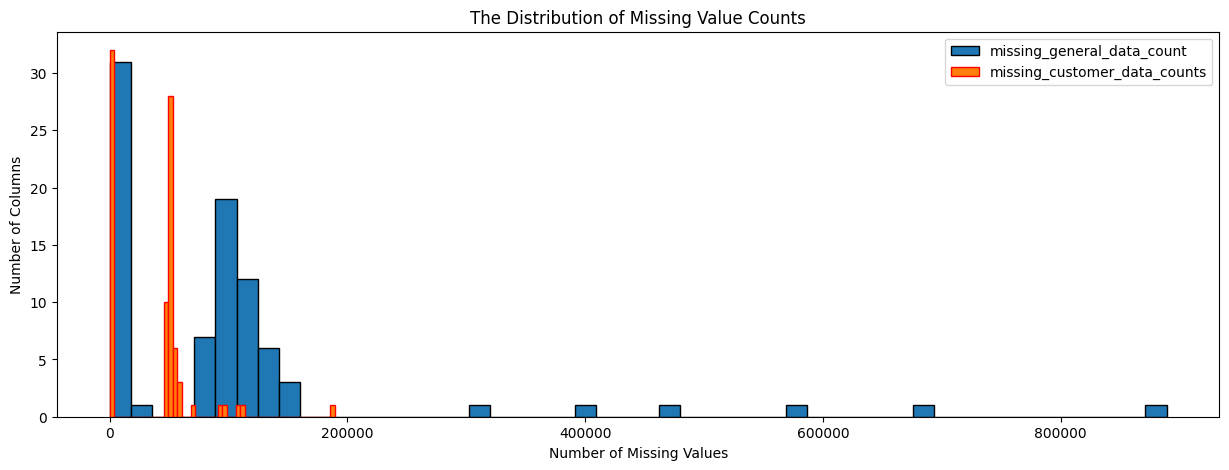

In [16]:
plt.figure(figsize=(15,5))
plt.hist(missing_general_data_counts, bins=50, edgecolor='k', label='missing_general_data_count')
plt.hist(missing_customer_data_counts, bins=50, edgecolor='r', label='missing_customer_data_counts')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Columns')
plt.title('The Distribution of Missing Value Counts')
plt.legend()
plt.show()

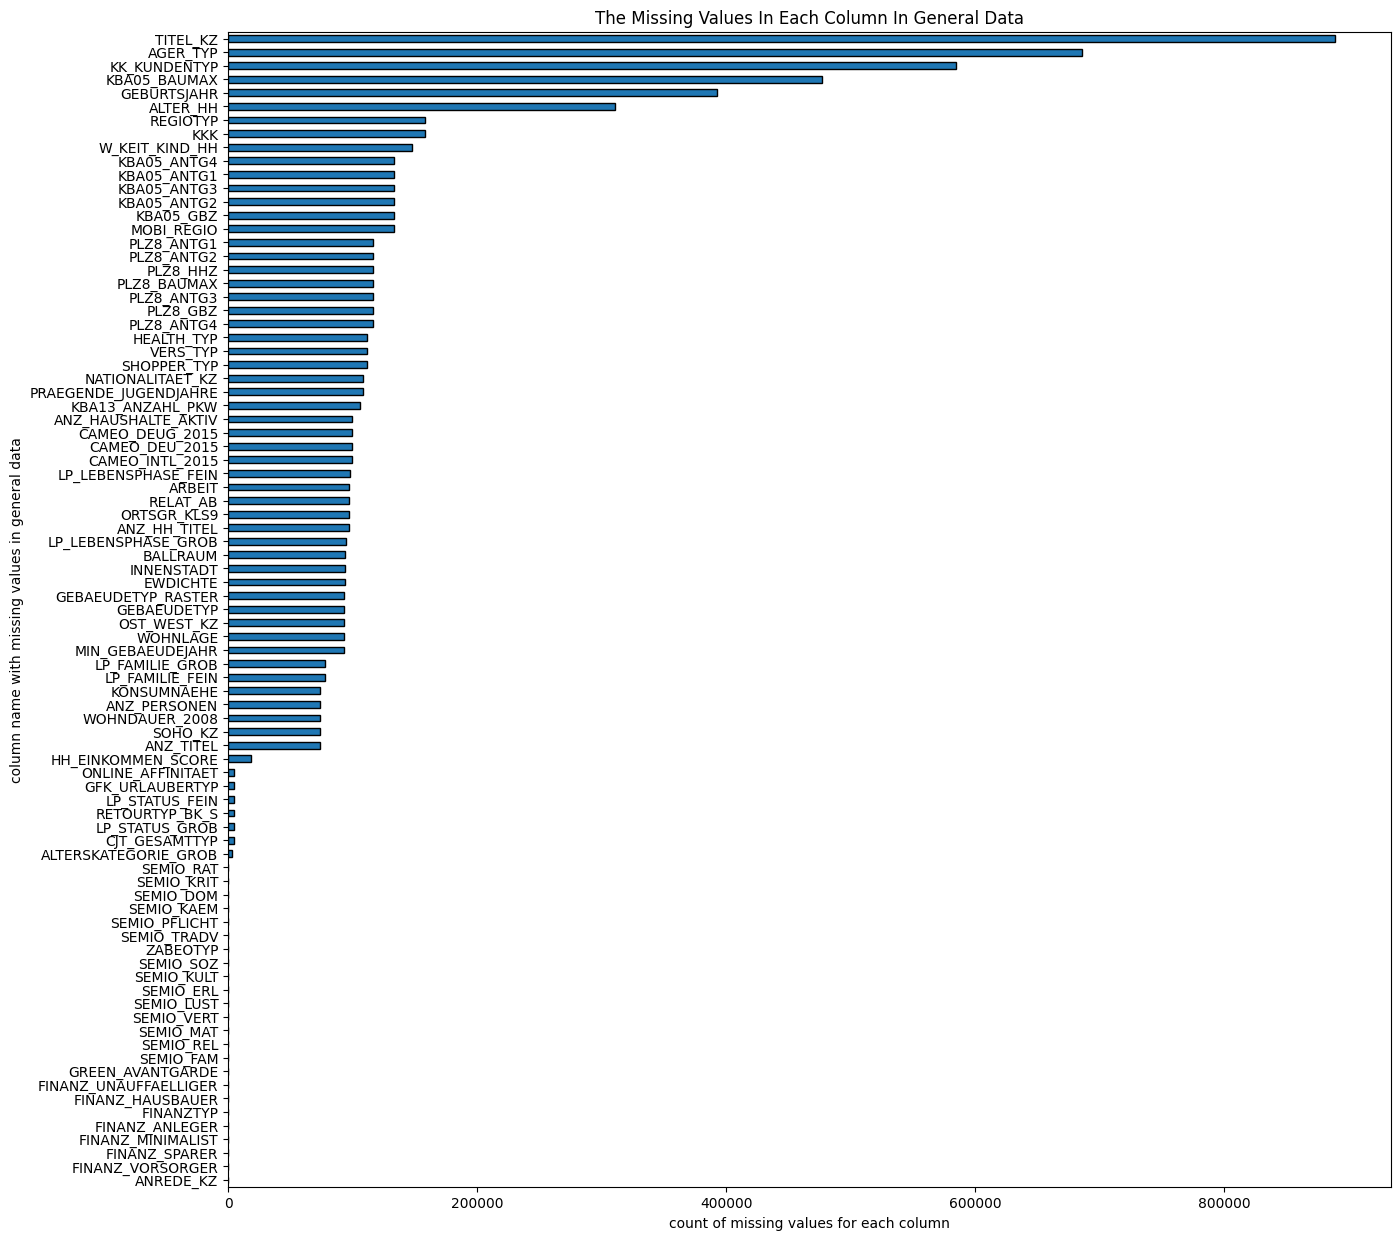

In [17]:
# Investigate patterns in the amount of missing data in each column.
missing_general_data_counts.plot.barh(edgecolor='k', label='missing_general_data_count', figsize=(15,15))
plt.title('The Missing Values In Each Column In General Data')
plt.xlabel('count of missing values for each column')
plt.ylabel('column name with missing values in general data')
plt.show()

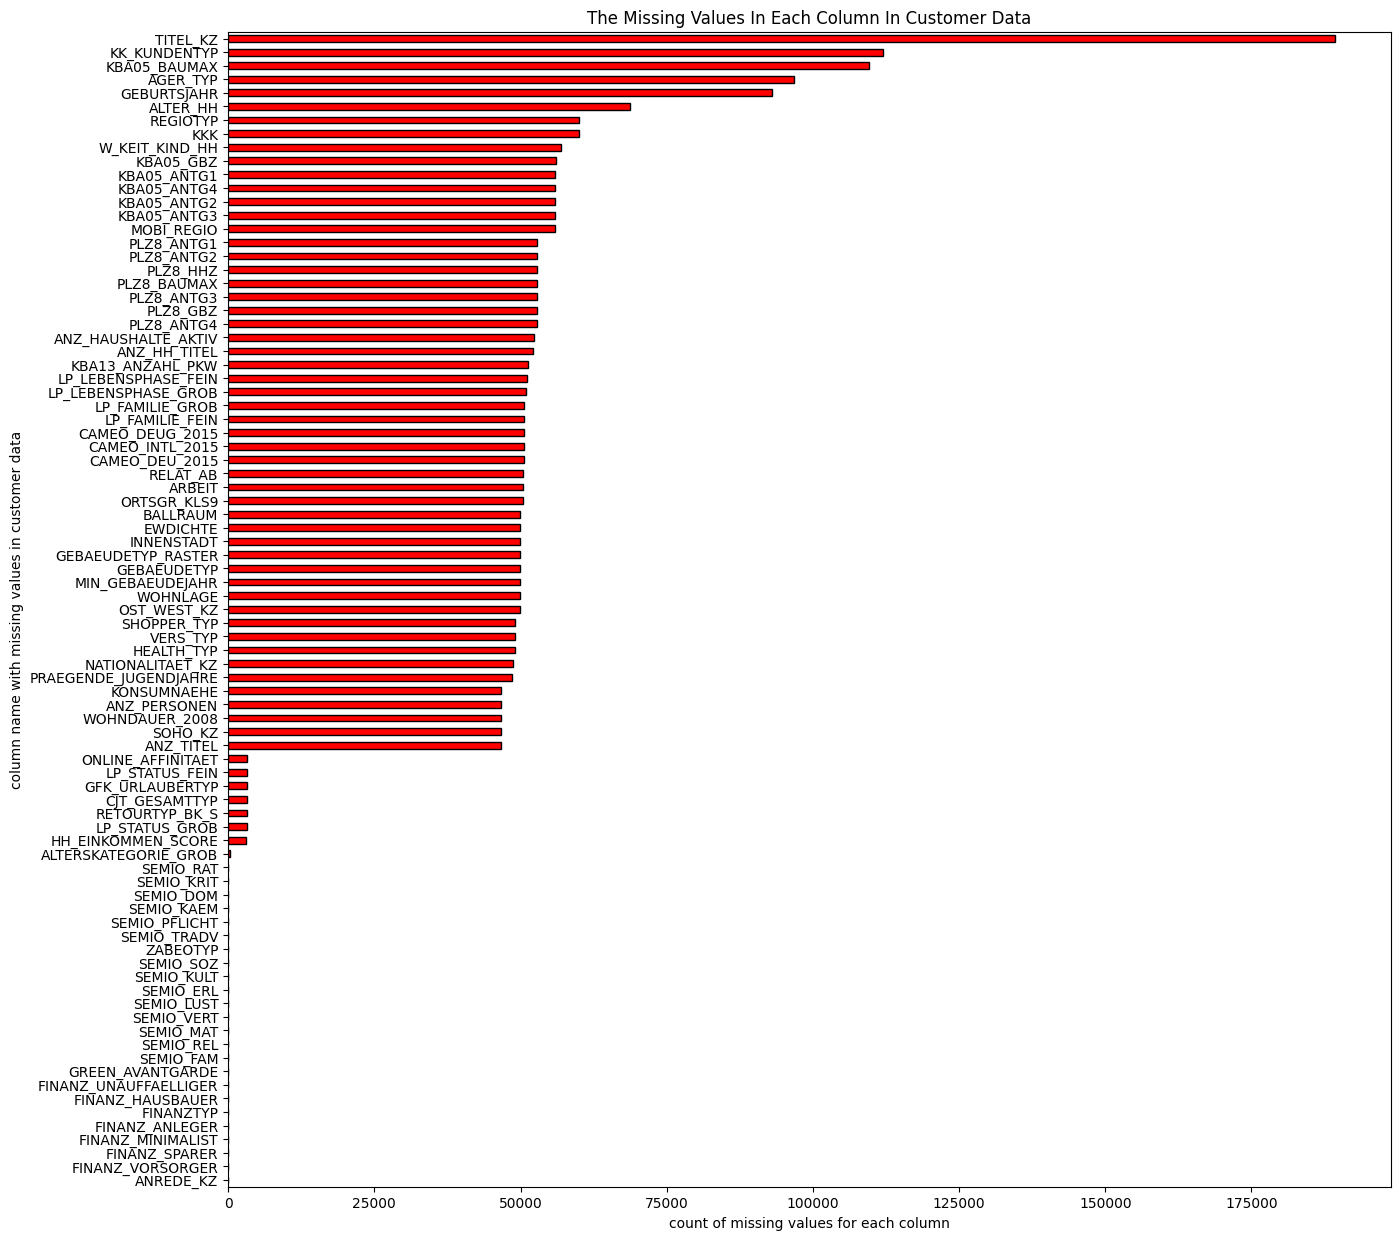

In [18]:
# Investigate patterns in the amount of missing data in each column.
missing_customer_data_counts.plot.barh(color='red', edgecolor='k', label='missing_customer_data_count', figsize=(15,15))
plt.title('The Missing Values In Each Column In Customer Data')
plt.xlabel('count of missing values for each column')
plt.ylabel('column name with missing values in customer data')
plt.show()

In [19]:
outlier_in_general_data = missing_general_data_counts [missing_general_data_counts > 200000]
print('the outliers in general data :')
display(outlier_in_general_data)
outlier_in_customer_data = missing_customer_data_counts [missing_customer_data_counts > 65000]
print('\nthe outliers in customer data :')
display(outlier_in_customer_data)

the outliers in general data :


,0
ALTER_HH,310267
GEBURTSJAHR,392318
KBA05_BAUMAX,476524
KK_KUNDENTYP,584612
AGER_TYP,685843
TITEL_KZ,889061



the outliers in customer data :


,0
ALTER_HH,68747
GEBURTSJAHR,93024
AGER_TYP,96738
KBA05_BAUMAX,109535
KK_KUNDENTYP,111937
TITEL_KZ,189340


In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

cleaned_general_data = modified_general_data.drop(columns=outlier_in_general_data.index)
cleaned_general_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   888340 non-null  float64
 1   ANREDE_KZ              891221 non-null  int64  
 2   CJT_GESAMTTYP          886367 non-null  float64
 3   FINANZ_MINIMALIST      891221 non-null  int64  
 4   FINANZ_SPARER          891221 non-null  int64  
 5   FINANZ_VORSORGER       891221 non-null  int64  
 6   FINANZ_ANLEGER         891221 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 8   FINANZ_HAUSBAUER       891221 non-null  int64  
 9   FINANZTYP              891221 non-null  int64  
 10  GFK_URLAUBERTYP        886367 non-null  float64
 11  GREEN_AVANTGARDE       891221 non-null  int64  
 12  HEALTH_TYP             780025 non-null  float64
 13  LP_LEBENSPHASE_FEIN    793589 non-null  float64
 14  LP_LEBENSPHASE_GROB    796649 non-nu

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

cleaned_customer_data = modified_customer_data.drop(columns=outlier_in_customer_data.index)
cleaned_customer_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   191412 non-null  float64
 1   ANREDE_KZ              191652 non-null  int64  
 2   CJT_GESAMTTYP          188439 non-null  float64
 3   FINANZ_MINIMALIST      191652 non-null  int64  
 4   FINANZ_SPARER          191652 non-null  int64  
 5   FINANZ_VORSORGER       191652 non-null  int64  
 6   FINANZ_ANLEGER         191652 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  191652 non-null  int64  
 8   FINANZ_HAUSBAUER       191652 non-null  int64  
 9   FINANZTYP              191652 non-null  int64  
 10  GFK_URLAUBERTYP        188439 non-null  float64
 11  GREEN_AVANTGARDE       191652 non-null  int64  
 12  HEALTH_TYP             142662 non-null  float64
 13  LP_LEBENSPHASE_FEIN    140599 non-null  float64
 14  LP_LEBENSPHASE_GROB    140711 non-nu

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

First of all, after loading the data, I tried to write a code that take the missing values from the feature summary file to use them in replacing the data with these values as indices by Numpy Nan, but It did not work , so I extract them manuallyu. I will keep trying to find the correct code to do this task.

As shown in the Data Frame of missing values number in general and customer data, and shown in the graphs, it is obivious that in general data there outliers columns that have more than 200000 missing value, so this number is assigned to be the threshold for the outliers. for the customer data, the threshold shown in the graphs is 70000. However, considering the number of outliers in general data and customer data, taking a threshold of 65000 would be better since it include the column of ALTER_HH also. Thus, the number of outliers in the general data and the customer data is the same so the analysis would be easier without affecting the results.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
# How much data is missing in each row of the dataset?

row_missing_general_data_counts = cleaned_general_data.isnull().sum(axis=1)
row_missing_general_data_counts.sort_values(ascending=False,inplace=True)
print('Missing data in general data in each row:')
row_missing_general_data_counts.head(20)


Missing data in general data in each row:


,0
643174,49
732775,49
472919,48
442178,47
442198,47
30418,47
30420,47
688695,47
688696,47
688760,47


In [23]:
# How much data is missing in each row of the dataset?

row_missing_customer_data_counts = cleaned_customer_data.isnull().sum(axis=1)
row_missing_customer_data_counts.sort_values(ascending=False,inplace=True)
print('Missing data in customer data in each row:')
row_missing_customer_data_counts.head(20)

Missing data in customer data in each row:


,0
128189,48
13188,48
22535,48
47192,47
47193,47
47195,47
47197,47
47199,47
47169,47
47170,47


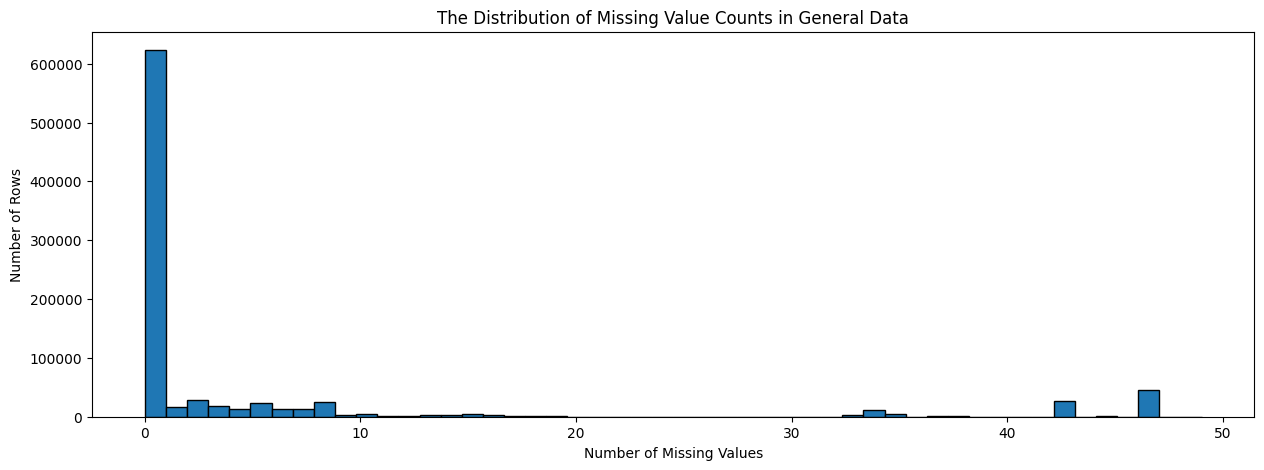

In [24]:
plt.figure(figsize=(15,5))
plt.hist(row_missing_general_data_counts, bins=50, edgecolor='k')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('The Distribution of Missing Value Counts in General Data')
plt.show()

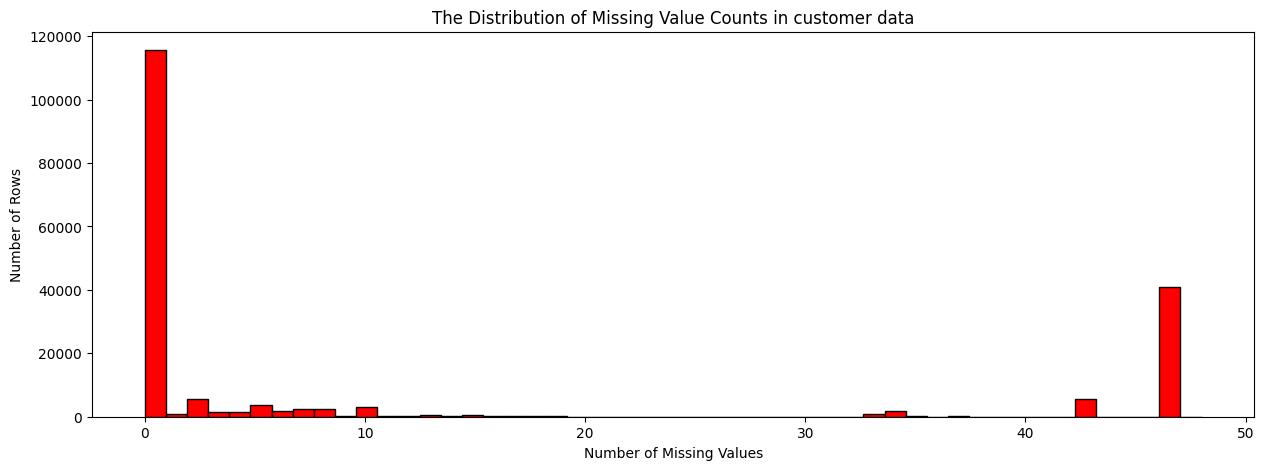

In [25]:
plt.figure(figsize=(15,5))
plt.hist(row_missing_customer_data_counts, color='r', bins=50, edgecolor='k')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('The Distribution of Missing Value Counts in customer data')
plt.show()

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

row_few_missing_general_data_index = row_missing_general_data_counts [row_missing_general_data_counts <= 20].index
row_few_missing_customer_data_index = row_missing_customer_data_counts [row_missing_customer_data_counts <= 20].index
row_many_missing_general_data_index = row_missing_general_data_counts [row_missing_general_data_counts > 20].index
row_many_missing_customer_data_index = row_missing_customer_data_counts [row_missing_customer_data_counts > 20].index
print(f"Rows with few missing values in general data: {len(row_few_missing_general_data_index)}")
print(f"Rows with few missing values in customer data: {len(row_few_missing_customer_data_index)}")
print(f"Rows with many missing values in general data: {len(row_many_missing_general_data_index)}")
print(f"Rows with many missing values in customer data: {len(row_many_missing_customer_data_index)}")

Rows with few missing values in general data: 797426
Rows with few missing values in customer data: 141640
Rows with many missing values in general data: 93795
Rows with many missing values in customer data: 50012


In [27]:
comparing_columns= ['ZABEOTYP' , 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP' , 'ALTERSKATEGORIE_GROB' , 'PLZ8_ANTG3']

In [28]:
#Convert to Data Frame
df_row_few_missing_general_data = cleaned_general_data.loc[row_few_missing_general_data_index]
df_row_many_missing_general_data = cleaned_general_data.loc[row_many_missing_general_data_index]
df_row_few_missing_customer_data = cleaned_customer_data.loc[row_few_missing_customer_data_index]
df_row_many_missing_customer_data = cleaned_customer_data.loc[row_many_missing_customer_data_index]

In [29]:
def compare_function (comparing_column):
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=comparing_column, data=df_row_few_missing_general_data, edgecolor='k')
    plt.title('few missing values')

    plt.subplot(1, 2, 2)
    sns.countplot(x=comparing_column, data=df_row_many_missing_general_data, color='g', edgecolor='k')
    plt.title('many missing values')

    plt.tight_layout()
    plt.show()


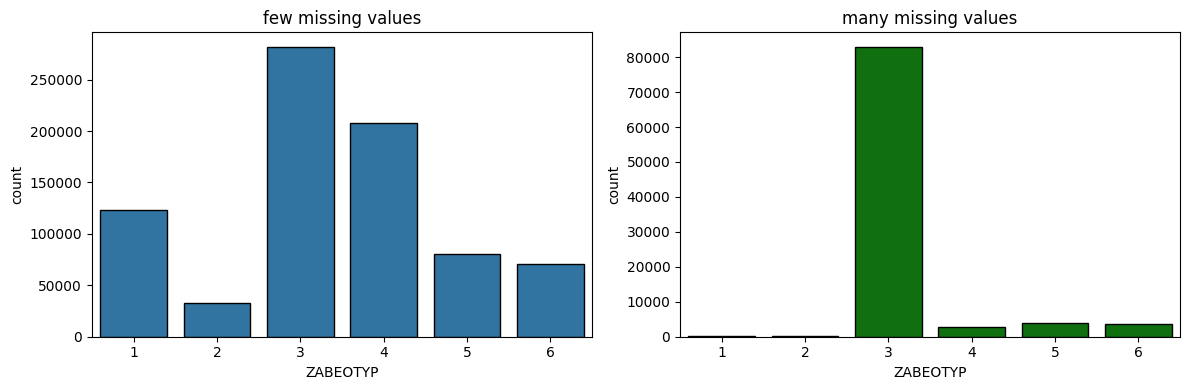

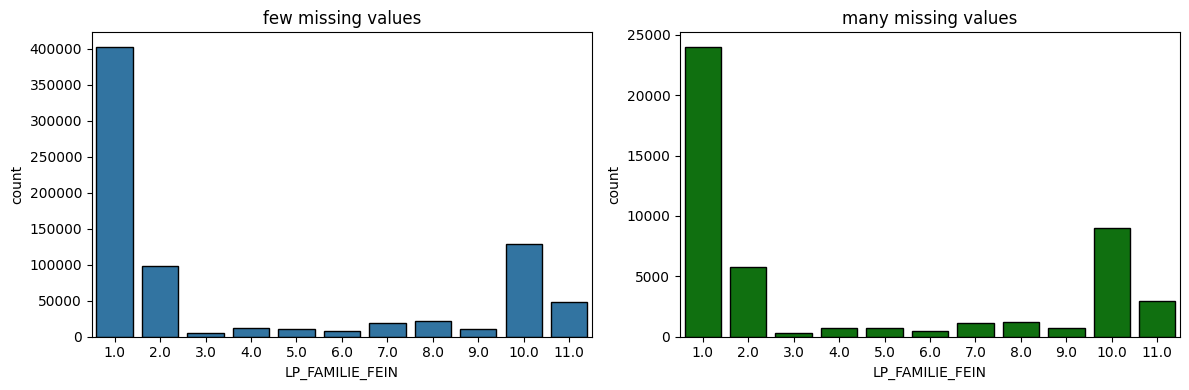

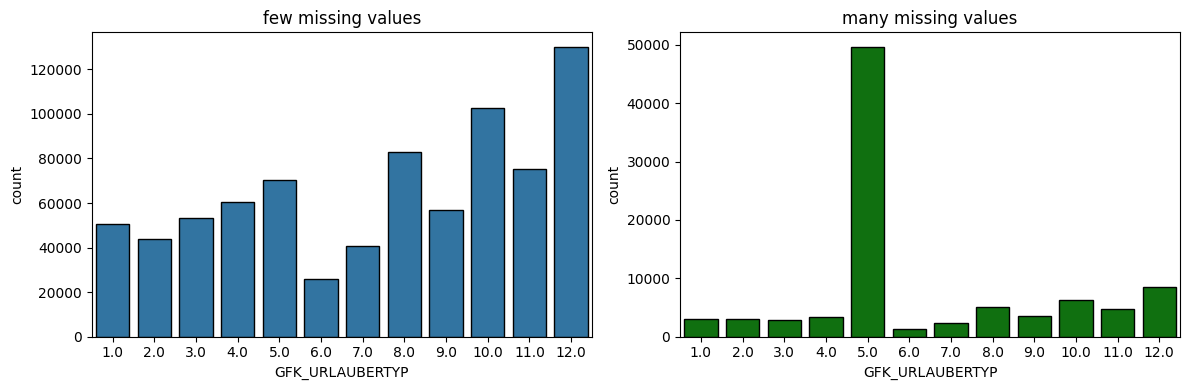

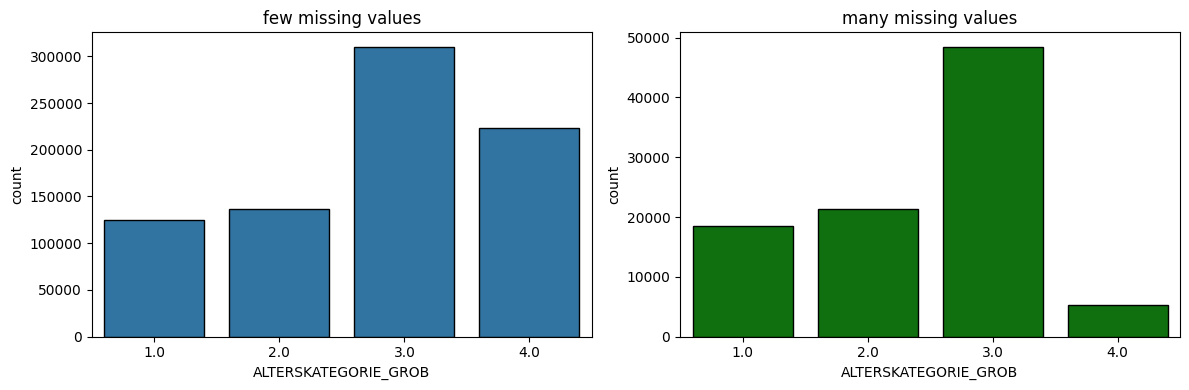

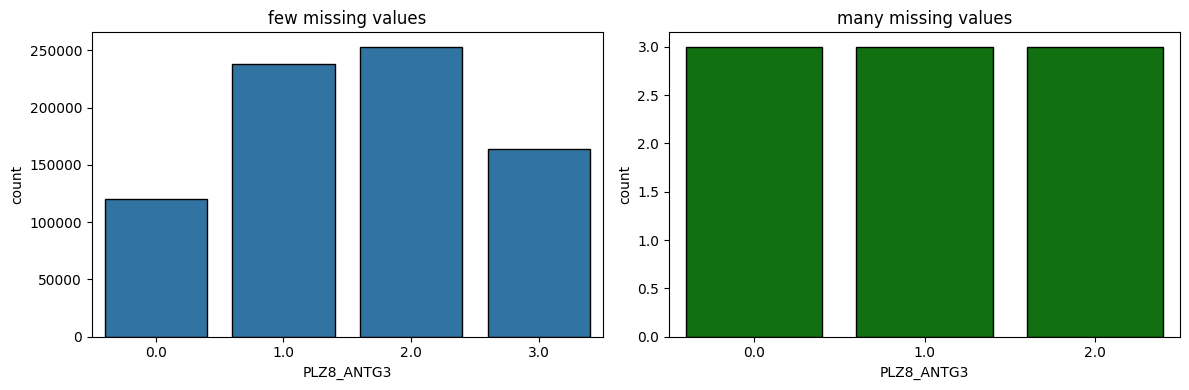

In [30]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
for i in comparing_columns:
    compare_function(i)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)
As shown in the above graphs, the rows that have no or few missing values can be considered as the rows that have less than 20 missing values for both the general and the customer data. also, it shown that there is no big differences between many missing data rown and  few or no missing values, so we can rely on the few missing rows in the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
# How many features are there of each data type?
#general data:

feat_info_general = Feature_Summary[Feature_Summary.attribute.isin(df_row_few_missing_general_data.columns)]
display(feat_info_general.head(50))
feat_info_general['type'].value_counts()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


,count
type,
ordinal,49
categorical,18
mixed,6
numeric,6


In [32]:
# How many features are there of each data type?
#customer data:

feat_info_customer = Feature_Summary[Feature_Summary.attribute.isin(df_row_few_missing_customer_data.columns)]
display(feat_info_customer.head(50))
feat_info_customer['type'].value_counts()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


,count
type,
ordinal,49
categorical,18
mixed,6
numeric,6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
#general data:
categorical_features_general = feat_info_general[feat_info_general['type'] == 'categorical']
print('the number of categorial features is', len(categorical_features_general))
categorical_features_general_list = categorical_features_general['attribute'].tolist()
unique_categorical_features_general_counts = df_row_few_missing_general_data[categorical_features_general_list].nunique()
binary_categoricals_general = unique_categorical_features_general_counts[unique_categorical_features_general_counts == 2]
multi_level_categoricals_general = unique_categorical_features_general_counts[unique_categorical_features_general_counts > 2]
print('the number of binary categorial features is', len(binary_categoricals_general), 'which are')
display(binary_categoricals_general)
print('the number of multi-level categorial features is', len(multi_level_categoricals_general), 'which are')
display(multi_level_categoricals_general)

the number of categorial features is 18
the number of binary categorial features is 5 which are


,0
ANREDE_KZ,2
GREEN_AVANTGARDE,2
SOHO_KZ,2
VERS_TYP,2
OST_WEST_KZ,2


the number of multi-level categorial features is 13 which are


,0
CJT_GESAMTTYP,6
FINANZTYP,6
GFK_URLAUBERTYP,12
LP_FAMILIE_FEIN,11
LP_FAMILIE_GROB,5
LP_STATUS_FEIN,10
LP_STATUS_GROB,5
NATIONALITAET_KZ,3
SHOPPER_TYP,4
ZABEOTYP,6


In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# customer data:
categorical_features_customer = feat_info_customer[feat_info_customer['type'] == 'categorical']
print('the number of categorial features is', len(categorical_features_customer))
categorical_features_customer_list = categorical_features_customer['attribute'].tolist()
unique_categorical_features_customer_counts = df_row_few_missing_customer_data[categorical_features_customer_list].nunique()
binary_categoricals_customer = unique_categorical_features_customer_counts[unique_categorical_features_customer_counts == 2]
multi_level_categoricals_customer = unique_categorical_features_customer_counts[unique_categorical_features_customer_counts > 2]
print('the number of binary categorial features is', len(binary_categoricals_customer), 'which are')
display(binary_categoricals_customer)
print('the number of multi-level categorial features is', len(multi_level_categoricals_customer), 'which are')
display(multi_level_categoricals_customer)

the number of categorial features is 18
the number of binary categorial features is 5 which are


,0
ANREDE_KZ,2
GREEN_AVANTGARDE,2
SOHO_KZ,2
VERS_TYP,2
OST_WEST_KZ,2


the number of multi-level categorial features is 13 which are


,0
CJT_GESAMTTYP,6
FINANZTYP,6
GFK_URLAUBERTYP,12
LP_FAMILIE_FEIN,11
LP_FAMILIE_GROB,5
LP_STATUS_FEIN,10
LP_STATUS_GROB,5
NATIONALITAET_KZ,3
SHOPPER_TYP,4
ZABEOTYP,6


In [35]:
#Check non numeric binary features:
binary_categoricals_general_list = binary_categoricals_general.index.tolist()
for i in binary_categoricals_general_list:
    print(df_row_few_missing_general_data[i].value_counts())


ANREDE_KZ
2    415781
1    381645
Name: count, dtype: int64
GREEN_AVANTGARDE
0    622259
1    175167
Name: count, dtype: int64
SOHO_KZ
0.0    790714
1.0      6712
Name: count, dtype: int64
VERS_TYP
2.0    394161
1.0    366848
Name: count, dtype: int64
OST_WEST_KZ
W    628987
O    168439
Name: count, dtype: int64


In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Binary Categories Re-encoding:
# general data
df_row_few_missing_general_data["ANREDE_KZ"] = df_row_few_missing_general_data["ANREDE_KZ"].replace({2:0,1:1})
print(df_row_few_missing_general_data["ANREDE_KZ"].value_counts())
df_row_few_missing_general_data["SOHO_KZ"] = df_row_few_missing_general_data["SOHO_KZ"].replace({0.0:0,1.0:1})
print(df_row_few_missing_general_data["SOHO_KZ"].value_counts())
df_row_few_missing_general_data["VERS_TYP"] = df_row_few_missing_general_data["VERS_TYP"].replace({2.0:0,1.0:1})
print(df_row_few_missing_general_data["VERS_TYP"].value_counts())
df_row_few_missing_general_data["OST_WEST_KZ"] = df_row_few_missing_general_data["OST_WEST_KZ"].replace({'W':0,'O':1})
print(df_row_few_missing_general_data["OST_WEST_KZ"].value_counts())
print(df_row_few_missing_general_data["GREEN_AVANTGARDE"].value_counts())


ANREDE_KZ
0    415781
1    381645
Name: count, dtype: int64
SOHO_KZ
0.0    790714
1.0      6712
Name: count, dtype: int64
VERS_TYP
0.0    394161
1.0    366848
Name: count, dtype: int64
OST_WEST_KZ
0    628987
1    168439
Name: count, dtype: int64
GREEN_AVANTGARDE
0    622259
1    175167
Name: count, dtype: int64


In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Binary Categories Re-encoding:
# customer data
df_row_few_missing_customer_data["ANREDE_KZ"] = df_row_few_missing_customer_data["ANREDE_KZ"].replace({2:0,1:1})
print(df_row_few_missing_customer_data["ANREDE_KZ"].value_counts())
df_row_few_missing_customer_data["SOHO_KZ"] = df_row_few_missing_customer_data["SOHO_KZ"].replace({0.0:0,1.0:1})
print(df_row_few_missing_customer_data["SOHO_KZ"].value_counts())
df_row_few_missing_customer_data["VERS_TYP"] = df_row_few_missing_customer_data["VERS_TYP"].replace({2.0:0,1.0:1})
print(df_row_few_missing_customer_data["VERS_TYP"].value_counts())
df_row_few_missing_customer_data["OST_WEST_KZ"] = df_row_few_missing_customer_data["OST_WEST_KZ"].replace({'W':0,'O':1})
print(df_row_few_missing_customer_data["OST_WEST_KZ"].value_counts())
print(df_row_few_missing_customer_data["GREEN_AVANTGARDE"].value_counts())


ANREDE_KZ
1    94804
0    46836
Name: count, dtype: int64
SOHO_KZ
0.0    140247
1.0      1393
Name: count, dtype: int64
VERS_TYP
1.0    70582
0.0    68739
Name: count, dtype: int64
OST_WEST_KZ
0    130301
1     11339
Name: count, dtype: int64
GREEN_AVANTGARDE
0    71280
1    70360
Name: count, dtype: int64


In [38]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Multi-Categories Re-Encoding
# general data
multi_level_categoricals_general_list = multi_level_categoricals_general.index.tolist()
dummies_df_row_few_missing_general_data = pd.get_dummies(data=df_row_few_missing_general_data,columns=multi_level_categoricals_general_list)
dummies_df_row_few_missing_general_data.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
730279,2.0,0,4,2,4,3,3,1,0,2.0,NaN,NaN,10.0,5.0,2,5,5,7,2,2,5,4,7,7,7,5,4,7,0.0,1.0,0.0,0.0,3.0,NaN,9.0,NaN,NaN,3.0,1997.0,0,4.0,43,NaN,NaN,NaN,NaN,NaN,7.0,2.0,8.0,4.0,3.0,NaN,3.0,5.0,469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,3.0,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [39]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Multi-Categories Re-Encoding
# customer data
multi_level_categoricals_customer_list = multi_level_categoricals_customer.index.tolist()
dummies_df_row_few_missing_customer_data = pd.get_dummies(data=df_row_few_missing_customer_data,columns=multi_level_categoricals_customer_list)
dummies_df_row_few_missing_customer_data.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
24453,4.0,0,3,1,5,1,3,3,0,2.0,NaN,NaN,5.0,5.0,2,1,4,4,4,5,7,1,4,7,6,6,4,1,0.0,1.0,0.0,0.0,4.0,NaN,4.0,6.0,0.0,1.0,2008.0,0,0.0,31,NaN,NaN,NaN,NaN,NaN,6.0,5.0,3.0,4.0,NaN,NaN,2.0,NaN,1238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,5.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,Fa

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
First of all, the number of categorical features was checked and splitted into binary and multi level subset of categorical features.Then, the binary features were replaced by zeros and ones. ALso, the multi level features were re-encoded using get dummies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

1.18. PRAEGENDE_JUGENDJAHRE

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

-1: unknown (eliminated)

0: unknown (eliminated)

1: 40s - war years (Mainstream, E+W)

2: 40s - reconstruction years (Avantgarde, E+W)

3: 50s - economic miracle (Mainstream, E+W)

4: 50s - milk bar / Individualisation (Avantgarde, E+W)

5: 60s - economic miracle (Mainstream, E+W)

6: 60s - generation 68 / student protestors (Avantgarde, W)

7: 60s - opponents to the building of the Wall (Avantgarde, E)

8: 70s - family orientation (Mainstream, E+W)

9: 70s - peace movement (Avantgarde, E+W)

10: 80s - Generation Golf (Mainstream, W)

11: 80s - ecological awareness (Avantgarde, W)

12: 80s - FDJ / communist party youth organisation (Mainstream, E)

13: 80s - Swords into ploughshares (Avantgarde, E)

14: 90s - digital media kids (Mainstream, E+W)

15: 90s - ecological awareness (Avantgarde, E+W)

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

PRAEGENDE_JUGENDJAHRE_decade = {1:0, 2:0, 3:1, 4:1, 5:2, 6:2, 7:2, 8:3, 9:3, 10:4, 11:4, 12:4, 13:4, 14:5, 15:5}
print('PRAEGENDE_JUGENDJAHRE_decade:')
display(PRAEGENDE_JUGENDJAHRE_decade)
PRAEGENDE_JUGENDJAHRE_movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
print('\nPRAEGENDE_JUGENDJAHRE_movement:')
display(PRAEGENDE_JUGENDJAHRE_movement)

PRAEGENDE_JUGENDJAHRE_decade:


{1: 0,
 2: 0,
 3: 1,
 4: 1,
 5: 2,
 6: 2,
 7: 2,
 8: 3,
 9: 3,
 10: 4,
 11: 4,
 12: 4,
 13: 4,
 14: 5,
 15: 5}


PRAEGENDE_JUGENDJAHRE_movement:


{1: 0,
 2: 1,
 3: 0,
 4: 1,
 5: 0,
 6: 1,
 7: 1,
 8: 0,
 9: 1,
 10: 0,
 11: 1,
 12: 0,
 13: 1,
 14: 0,
 15: 1}

In [41]:
#Create copied features
dummies_df_row_few_missing_general_data["PRAEGENDE_JUGENDJAHRE_DECADE"] = dummies_df_row_few_missing_general_data.PRAEGENDE_JUGENDJAHRE
dummies_df_row_few_missing_general_data["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = dummies_df_row_few_missing_general_data.PRAEGENDE_JUGENDJAHRE
dummies_df_row_few_missing_customer_data["PRAEGENDE_JUGENDJAHRE_DECADE"] = dummies_df_row_few_missing_customer_data.PRAEGENDE_JUGENDJAHRE
dummies_df_row_few_missing_customer_data["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = dummies_df_row_few_missing_customer_data.PRAEGENDE_JUGENDJAHRE


In [42]:
#Replace the copied features with actual values
dummies_df_row_few_missing_general_data["PRAEGENDE_JUGENDJAHRE_DECADE"] = dummies_df_row_few_missing_general_data["PRAEGENDE_JUGENDJAHRE_DECADE"].replace(PRAEGENDE_JUGENDJAHRE_decade)
dummies_df_row_few_missing_general_data["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = dummies_df_row_few_missing_general_data["PRAEGENDE_JUGENDJAHRE_MOVEMENT"].replace(PRAEGENDE_JUGENDJAHRE_movement)
dummies_df_row_few_missing_customer_data["PRAEGENDE_JUGENDJAHRE_DECADE"] = dummies_df_row_few_missing_customer_data["PRAEGENDE_JUGENDJAHRE_DECADE"].replace(PRAEGENDE_JUGENDJAHRE_decade)
dummies_df_row_few_missing_customer_data["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = dummies_df_row_few_missing_customer_data["PRAEGENDE_JUGENDJAHRE_MOVEMENT"].replace(PRAEGENDE_JUGENDJAHRE_movement)

In [43]:
#Eliminate the original feature
dummies_df_row_few_missing_general_data=dummies_df_row_few_missing_general_data.drop("PRAEGENDE_JUGENDJAHRE", axis=1)

In [44]:
#Eliminate the original feature
dummies_df_row_few_missing_customer_data=dummies_df_row_few_missing_customer_data.drop("PRAEGENDE_JUGENDJAHRE", axis=1)

4.3. CAMEO_INTL_2015

German CAMEO: Wealth / Life Stage Typology, mapped to international code

-1: unknown (eliminated)

11: Wealthy Households - Pre-Family Couples & Singles

12: Wealthy Households - Young Couples With Children

13: Wealthy Households - Families With School Age Children

14: Wealthy Households - Older Families & Mature Couples

15: Wealthy Households - Elders In Retirement

21: Prosperous Households - Pre-Family Couples & Singles

22: Prosperous Households - Young Couples With Children

23: Prosperous Households - Families With School Age Children

24: Prosperous Households - Older Families & Mature Couples

25: Prosperous Households - Elders In Retirement

31: Comfortable Households - Pre-Family Couples & Singles

32: Comfortable Households - Young Couples With Children

33: Comfortable Households - Families With School Age Children

34: Comfortable Households - Older Families & Mature Couples

35: Comfortable Households - Elders In Retirement

41: Less Affluent Households - Pre-Family Couples & Singles

42: Less Affluent Households - Young Couples With Children

43: Less Affluent Households - Families With School Age Children

44: Less Affluent Households - Older Families & Mature Couples

45: Less Affluent Households - Elders In Retirement

51: Poorer Households - Pre-Family Couples & Singles

52: Poorer Households - Young Couples With Children

53: Poorer Households - Families With School Age Children

54: Poorer Households - Older Families & Mature Couples

55: Poorer Households - Elders In Retirement

XX: unknown (eliminated)


In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

dummies_df_row_few_missing_general_data["CAMEO_INTL_2015"] = pd.to_numeric(dummies_df_row_few_missing_general_data["CAMEO_INTL_2015"])
dummies_df_row_few_missing_customer_data["CAMEO_INTL_2015"] = pd.to_numeric(dummies_df_row_few_missing_customer_data["CAMEO_INTL_2015"])

CAMEO_INTL_2015_wealth = {11:1, 12:1, 13:1, 14:1, 15:1,
                          21:2, 22:2, 23:2, 24:2, 25:2,
                          31:3, 32:3, 33:3, 34:3, 35:3,
                          41:4, 42:4, 43:4, 44:4, 45:4,
                          51:5, 52:5, 53:5, 54:5, 55:5}

CAMEO_INTL_2015_life_stage = {11:1, 12:2, 13:3, 14:4, 15:5,
                          21:1, 22:2, 23:3, 24:4, 25:5,
                          31:1, 32:2, 33:3, 34:4, 35:5,
                          41:1, 42:2, 43:3, 44:4, 45:5,
                          51:1, 52:2, 53:3, 54:4, 55:5}

In [46]:
#Create copied features
#general data
dummies_df_row_few_missing_general_data["CAMEO_INTL_2015_WEALTH"] = dummies_df_row_few_missing_general_data.CAMEO_INTL_2015
dummies_df_row_few_missing_general_data["CAMEO_INTL_2015_LIFE_STAGE"] = dummies_df_row_few_missing_general_data.CAMEO_INTL_2015

In [47]:
#Create copied features
#customer data
dummies_df_row_few_missing_customer_data["CAMEO_INTL_2015_WEALTH"] = dummies_df_row_few_missing_customer_data.CAMEO_INTL_2015
dummies_df_row_few_missing_customer_data["CAMEO_INTL_2015_LIFE_STAGE"] = dummies_df_row_few_missing_customer_data.CAMEO_INTL_2015

In [48]:
#Replace the copied features with actual values
#general data
dummies_df_row_few_missing_general_data["CAMEO_INTL_2015_WEALTH"] = dummies_df_row_few_missing_general_data["CAMEO_INTL_2015_WEALTH"].replace(CAMEO_INTL_2015_wealth)
dummies_df_row_few_missing_general_data["CAMEO_INTL_2015_LIFE_STAGE"] = dummies_df_row_few_missing_general_data["CAMEO_INTL_2015_LIFE_STAGE"].replace(CAMEO_INTL_2015_life_stage)


In [49]:
#Replace the copied features with actual values
#customer data
dummies_df_row_few_missing_customer_data["CAMEO_INTL_2015_WEALTH"] = dummies_df_row_few_missing_customer_data["CAMEO_INTL_2015_WEALTH"].replace(CAMEO_INTL_2015_wealth)
dummies_df_row_few_missing_customer_data["CAMEO_INTL_2015_LIFE_STAGE"] = dummies_df_row_few_missing_customer_data["CAMEO_INTL_2015_LIFE_STAGE"].replace(CAMEO_INTL_2015_life_stage)


In [50]:
#Eliminate the original feature
dummies_df_row_few_missing_general_data=dummies_df_row_few_missing_general_data.drop("CAMEO_INTL_2015", axis=1)
dummies_df_row_few_missing_customer_data=dummies_df_row_few_missing_customer_data.drop("CAMEO_INTL_2015", axis=1)

In [51]:
print(dummies_df_row_few_missing_customer_data.shape)
dummies_df_row_few_missing_general_data.head(5)

(141640, 195)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
730279,2.0,0,4,2,4,3,3,1,0,2.0,NaN,NaN,5.0,2,5,5,7,2,2,5,4,7,7,7,5,4,7,0.0,1.0,0.0,0.0,3.0,NaN,9.0,NaN,NaN,3.0,1997.0,0,4.0,NaN,NaN,NaN,NaN,NaN,7.0,2.0,8.0,4.0,3.0,NaN,3.0,5.0,469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,3.0,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [52]:
print(dummies_df_row_few_missing_customer_data.shape)
dummies_df_row_few_missing_customer_data.head(5)

(141640, 195)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
24453,4.0,0,3,1,5,1,3,3,0,2.0,NaN,NaN,5.0,2,1,4,4,4,5,7,1,4,7,6,6,4,1,0.0,1.0,0.0,0.0,4.0,NaN,4.0,6.0,0.0,1.0,2008.0,0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,5.0,3.0,4.0,NaN,NaN,2.0,NaN,1238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,5.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For the specified mixed-level features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, the data was splitted into two features for each one, so the data could be easier to handle. Then, the original features were dropped since they are replaced so there is no need for them.

The other mixed-level features will be dropped.

#### Step 1.2.3: Complete Feature Selection


In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [53]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

mixed_features = feat_info_general[feat_info_general['type'] == 'mixed']
print("features to be eliminated:")
display(mixed_features)
for mixed in mixed_features['attribute']:
  if mixed in dummies_df_row_few_missing_general_data.columns:
    print("the feature", mixed, "will be removed from the general data")
    dummies_df_row_few_missing_general_data=dummies_df_row_few_missing_general_data.drop(mixed, axis=1)

for mixed in mixed_features['attribute']:
  if mixed in dummies_df_row_few_missing_customer_data.columns:
    print("the feature", mixed, "will be removed from the customer data")
    dummies_df_row_few_missing_customer_data=dummies_df_row_few_missing_customer_data.drop(mixed, axis=1)


features to be eliminated:


,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


the feature LP_LEBENSPHASE_FEIN will be removed from the general data
the feature LP_LEBENSPHASE_GROB will be removed from the general data
the feature WOHNLAGE will be removed from the general data
the feature PLZ8_BAUMAX will be removed from the general data
the feature LP_LEBENSPHASE_FEIN will be removed from the customer data
the feature LP_LEBENSPHASE_GROB will be removed from the customer data
the feature WOHNLAGE will be removed from the customer data
the feature PLZ8_BAUMAX will be removed from the customer data


In [54]:
processed_general_data = dummies_df_row_few_missing_general_data
print("The shape of the processed_general_data is:",processed_general_data.shape)
processed_general_data.head(5)

The shape of the processed_general_data is: (797426, 192)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
730279,2.0,0,4,2,4,3,3,1,0,2.0,5.0,2,5,5,7,2,2,5,4,7,7,7,5,4,7,0.0,1.0,0.0,0.0,3.0,NaN,9.0,NaN,NaN,3.0,1997.0,0,NaN,NaN,NaN,NaN,NaN,7.0,2.0,8.0,4.0,3.0,NaN,3.0,5.0,469.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,3.0,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Tru

In [55]:
processed_customer_data = dummies_df_row_few_missing_customer_data
print("The shape of the processed_customer_data is:",processed_customer_data.shape)
processed_customer_data.head(5)

The shape of the processed_customer_data is: (141640, 191)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
24453,4.0,0,3,1,5,1,3,3,0,2.0,5.0,2,1,4,4,4,5,7,1,4,7,6,6,4,1,0.0,1.0,0.0,0.0,4.0,NaN,4.0,6.0,0.0,1.0,2008.0,0,NaN,NaN,NaN,NaN,NaN,6.0,5.0,3.0,4.0,NaN,NaN,2.0,NaN,1238.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,5.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,Fa

In [56]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [57]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...


    # remove selected columns and rows, ...


    # select, re-encode, and engineer column values.


    # Return the cleaned dataframe.

"In each step, I handled the both datasets, the general data and the customer data. So, this step is already done"

'In each step, I handled the both datasets, the general data and the customer data. So, this step is already done'

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [59]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# general data:
print("Number of missing in general data", processed_general_data.isnull().sum().sum())

bool_columns_general = processed_general_data.select_dtypes(include='bool').columns
processed_general_data = processed_general_data.copy()
processed_general_data[bool_columns_general] = processed_general_data[bool_columns_general].astype(int)

numeric_columns_general = processed_general_data.select_dtypes(include=['float64','int64','uint8','int32','int8']).columns
dummy_columns_general = processed_general_data.select_dtypes(include=['object']).columns

print("Numeric columns:", len(numeric_columns_general))
print("Dummy columns:", len(dummy_columns_general))
print("Boolean columns:", len(bool_columns_general))

imp_mean = SimpleImputer(strategy='mean')
if len(numeric_columns_general) == 0:
    general_numeric_imputed = pd.DataFrame()
else:
    general_numeric_imputed = pd.DataFrame(imp_mean.fit_transform(processed_general_data[numeric_columns_general]),columns=numeric_columns_general)


imp_mode = SimpleImputer(strategy='most_frequent')
if len(dummy_columns_general) == 0:
    general_dummy_imputed = pd.DataFrame()
else:
    general_dummy_imputed = pd.DataFrame(imp_mode.fit_transform(processed_general_data[dummy_columns_general]),columns=dummy_columns_general)

NanCleaned_general_data = pd.concat([general_numeric_imputed, general_dummy_imputed], axis=1)

NanCleaned_general_data = NanCleaned_general_data[processed_general_data.columns]

print("Number of missing in general data after cleaning", NanCleaned_general_data.isnull().sum().sum())

Number of missing in general data 751879
Numeric columns: 192
Dummy columns: 0
Boolean columns: 128
Number of missing in general data after cleaning 0


In [60]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# customer data:
print("Number of missing in customer data", processed_customer_data.isnull().sum().sum())

bool_columns_customer = processed_customer_data.select_dtypes(include='bool').columns
processed_customer_data = processed_customer_data.copy()      # avoid SettingWithCopy
processed_customer_data[bool_columns_customer] = processed_customer_data[bool_columns_customer].astype(int)

numeric_columns_customer = processed_customer_data.select_dtypes(include=['float64','int64','uint8','int32','int8']).columns
dummy_columns_customer = processed_customer_data.select_dtypes(include=['object']).columns

print("Numeric columns:", len(numeric_columns_customer))
print("Dummy columns:", len(dummy_columns_customer))
print("Boolean columns:", len(bool_columns_customer))

imp_mean = SimpleImputer(strategy='mean')
if len(numeric_columns_customer) == 0:
    customer_numeric_imputed = pd.DataFrame()
else:
    customer_numeric_imputed = pd.DataFrame(imp_mean.fit_transform(processed_customer_data[numeric_columns_customer]),columns=numeric_columns_customer)


imp_mode = SimpleImputer(strategy='most_frequent')
if len(dummy_columns_customer) == 0:
    customer_dummy_imputed = pd.DataFrame()
else:
    customer_dummy_imputed = pd.DataFrame(imp_mode.fit_transform(processed_customer_data[dummy_columns_customer]),columns=dummy_columns_customer)

NanCleaned_customer_data = pd.concat([customer_numeric_imputed, customer_dummy_imputed], axis=1)

NanCleaned_customer_data = NanCleaned_customer_data[processed_customer_data.columns]

print("Number of missing in customer data after cleaning", NanCleaned_customer_data.isnull().sum().sum())

Number of missing in customer data 102893
Numeric columns: 191
Dummy columns: 0
Boolean columns: 127
Number of missing in customer data after cleaning 0


In [61]:
# Apply feature scaling to the general population demographics data.
scaler =StandardScaler()

In [62]:
general_features_scaled=scaler.fit_transform(NanCleaned_general_data)

In [63]:
general_features_scaled=pd.DataFrame(general_features_scaled,columns=NanCleaned_general_data.columns.tolist())

In [64]:
general_features_scaled.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-7.822246e-01,-0.958071,0.683150,-0.481928,0.411731,0.108283,0.244962,-1.502317,-0.530567,-0.270002,1.073737,-1.102885,0.463466,0.526793,1.626943,-1.171042,-1.109850,0.206743,-0.067639,1.879115,1.392858,1.339202,0.377869,-0.099402,1.855007,-0.092133,1.06107,-1.495517,-0.06057,-0.915546,5.188722e-16,0.566714,0.000000,0.000000,-0.014789,1.132135,-0.517488,0.0,0.0,0.0,0.0,0.0,1.304213,-1.128680,1.701404,0.283581,2.944039e-01,0.0,0.172170,0.299805,-4.465558e-01,0.0,4.895716e-16,0.0,0.0,0.0,0.0,-1.171103,-0.127810,-0.052483,-0.363932,-0.463888,-0.475666,-0.575058,2.486014,-0.382882,-0.572594,-0.388744,4.105154,-0.274526,-0.392118,-0.75398,-0.260429,-0.240828,-0.267084,-0.286309,-0.311379,-0.182598,-0.231812,-0.34088,3.601467,-0.384665,-0.322372,-0.441525,-1.009237,-0.375455,-0.076876,-0.121359,-0.11917,-0.103922,-0.15862,-0.167562,-0.115244,-0.

In [65]:
general_features_scaled.shape

(797426, 192)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
For the NaN values in the general and the customer data, the function SimplImputer was sed to replace them according to their feature type. the mean strategy was used for numeric while the most frequent strategy was used for the dummies. Then,  the feature scaling was implemented to the general data using the Standard Scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the data.
pca = PCA(random_state=42)
pca.fit(general_features_scaled)

In [ ]:
# Investigate the variance accounted for by each principal component.

variance_ratio = pca.explained_variance_ratio_
variance = pca.explained_variance_

print("Explained Variance Ratio:")
print(variance_ratio)

print("\nTotal variance explained:", variance_ratio.sum())

In [ ]:
# Investigate the variance accounted for by each principal component.

num_components = np.arange(len(variance_ratio))
values = variance_ratio
plt.bar(num_components,values)
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Explained variance per principal component")
plt.show()

In [ ]:
# Investigate the variance accounted for by each principal component.
cumulative_variance = np.cumsum(variance_ratio)

print("Cumulative variance:")
print(cumulative_variance)

In [ ]:

# Investigate the variance accounted for by each principal component.
plt.plot(num_components,cumulative_variance)
plt.xlabel("Principal component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance per principal component")
plt.show()

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_50 = PCA(n_components=50)
general_data_PCA = pca_50.fit_transform(general_features_scaled)
print("PCA complete shape:", general_data_PCA.shape)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def PCA_weights(df,pca,n):
    weights_df = pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df

In [ ]:
PCA_weights(general_features_scaled,pca_50,0)

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCA_weights(general_features_scaled,pca_50,1)

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCA_weights(general_features_scaled,pca_50,2)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
sample_size = 50000
np.random.seed(42)

idx = np.random.choice(general_data_PCA.shape[0], sample_size, replace=False)
general_data_PCA_sample = general_data_PCA[idx]

print("Sample shape:", general_data_PCA_sample.shape)

In [ ]:
# Over a number of different cluster counts...
num_clusters = range(4, 15)
scores = []

    # run k-means clustering on the data and...
for k in num_clusters:
    km = KMeans(n_clusters=k, random_state=42)
    # compute the average within-cluster distances.
    km.fit(general_data_PCA_sample)
    scores.append(km.inertia_)

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10,5))
plt.plot(num_clusters, scores, marker='o')
plt.xlabel("k (clusters)")
plt.ylabel("Inertia (lower is better)")
plt.title("Elbow Method on PCA-sampled data")
plt.grid(True)
plt.show()

In [ ]:
best_k = 13

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

mini_kmeans = MiniBatchKMeans(
    n_clusters=best_k,
    batch_size=2048,
    random_state=42
)

model = mini_kmeans.fit(general_data_PCA)
general_clusters_full = mini_kmeans.labels_
general_data_predicition = model.predict(general_data_PCA)

In [ ]:
NanCleaned_general_data["CLUSTER"] = general_clusters_full
NanCleaned_general_data.head()

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
#customers =
"The customer data is already loaded"

In [ ]:
# Align customer columns to match general data columns (except cluster column)
general_cols = NanCleaned_general_data.columns.drop("CLUSTER")

# Add missing columns to customer data
for col in general_cols:
    if col not in NanCleaned_customer_data.columns:
        NanCleaned_customer_data[col] = 0

# Remove extra unexpected columns in customer data
NanCleaned_customer_data = NanCleaned_customer_data[general_cols]

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_features_scaled=scaler.transform(NanCleaned_customer_data)


In [ ]:
customer_features_scaled=pd.DataFrame(customer_features_scaled,columns=NanCleaned_customer_data.columns.tolist())

In [ ]:
customer_features_scaled.head(10)

In [ ]:
customer_features_scaled.shape

In [ ]:
customer_data_PCA = pca_50.transform(customer_features_scaled)

In [ ]:
customer_data_predicition = model.predict(customer_data_PCA)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
general_series = pd.Series(general_data_predicition)
customer_series = pd.Series(customer_data_predicition)

general_counts = general_series.value_counts().sort_index()
customer_counts = customer_series.value_counts().sort_index()

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def compare_plot(general_counts, customer_counts):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].set_title("General Clusters")
    sns.barplot(x=general_counts.index, y=general_counts.values, ax=axes[0], edgecolor='k')

    axes[1].set_title("Customer Clusters")
    sns.barplot(x=customer_counts.index, y=customer_counts.values, ax=axes[1], color='r', edgecolor='k')

    plt.show()

In [ ]:
compare_plot(general_counts, customer_counts)

In [ ]:
positive_corr=["LP_STATUS_GROB_1.0","HH_EINKOMMEN_SCORE","WEALTH","PLZ8_ANTG3","ALTERSKATEGORIE_GROB","FINANZ_VORSORGER","ZABEOTYP_3.0","SEMIO_ERL",
"ANREDE_KZ","SEMIO_VERT","SEMIO_FAM","SEMIO_SOZ"]
negative_corr=["FINANZ_MINIMALIST","MOBI_REGIO","PLZ8_ANTG1","KBA05_GBZ","DECADE","FINANZ_SPARER","FINANZ_UNAUFFAELLIGER","SEMIO_REL",
             "SEMIO_KAEM","SEMIO_DOM","SEMIO_KRIT","SEMIO_ERL"]

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_10 = scaler.inverse_transform(pca_50.inverse_transform(model.cluster_centers_[10].reshape(1, -1))).flatten()


In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_12 = scaler.inverse_transform(pca_50.inverse_transform(model.cluster_centers_[12].reshape(1, -1))).flatten()


In [ ]:
centroids=pd.DataFrame({"feature":NanCleaned_customer_data.columns,"centroid_10":centroid_10,"centroid_12":centroid_12})


In [ ]:
centroids[centroids["feature"].isin(positive_corr)]


In [ ]:
centroids[centroids["feature"].isin(negative_corr)]


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:
hhh

In [ ]:
!jupyter nbconvert --to html Identify_Customer_Segments.ipynb